# Vehicle Price Prediction
The following shows the steps in developing an algorithm to predict vehicle price based on a dataset.
- Dataset source: Kaggley
- Methodology: Linear Regression 
- Tool: Scikit-learn, Numpy, Pandas


In [396]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings 
warnings.filterwarnings("ignore", category = FutureWarning)

## Data Import and Preview
Import the data using Pandas' csv reader and provide overview

In [397]:
dat_url = "https://raw.githubusercontent.com/hailend/vehicle_price/main/car_price.csv"
car_price_data = pd.read_csv(dat_url) 
car_price_data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [361]:
print(f"The dataset contains {car_price_data.shape[0]} rows and {car_price_data.shape[1]} columns")

The dataset contains 205 rows and 26 columns


There are 205 cars, each consisting 26 features. Let's see if there are NAs in the dataset. 

In [398]:
car_price_data.isna().sum()

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

There are no NAs in the dataset. The datatypes of each column is shown below.

In [399]:
car_price_data.dtypes

car_ID                int64
symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
dtype: object

## Visualize
Let's do preliminary visualization to see how different features relate to the price parameter. The following function accepts input arguments x and y and creates a number of scatter plots.

In [400]:
def create_scatter_plot(ax, x, y, r, c):
    #Args: 
    # fg: figure attributes
    # x: x variable(s) -- one or more variables
    # y: one variable only
    # c: # of columns in a grid 
    # r: # of rows in a grid
    k = 0
    for j in range(c):
        for i in range(r):
        #    ax[i].scatter(first_vis[:,i], first_vis[:, 5])
            ax[i,j].scatter(x.iloc[:,k], y, s = 100, edgecolor = "black")
            ax[i,j].set_xlabel(x.columns[k])
            ax[i,j].set_ylabel("Price")
            k = k + 1
    plt.show()

Let's see some features and how they correlate with our target variabe, price.The following set of scatter plots show features with possible direct and obvious impact on price. For visualizaiton, all features except car_Id, symboling, CarName, and enginelocation have been considered.

Below is the scatter plots that show correlations of these features to the price

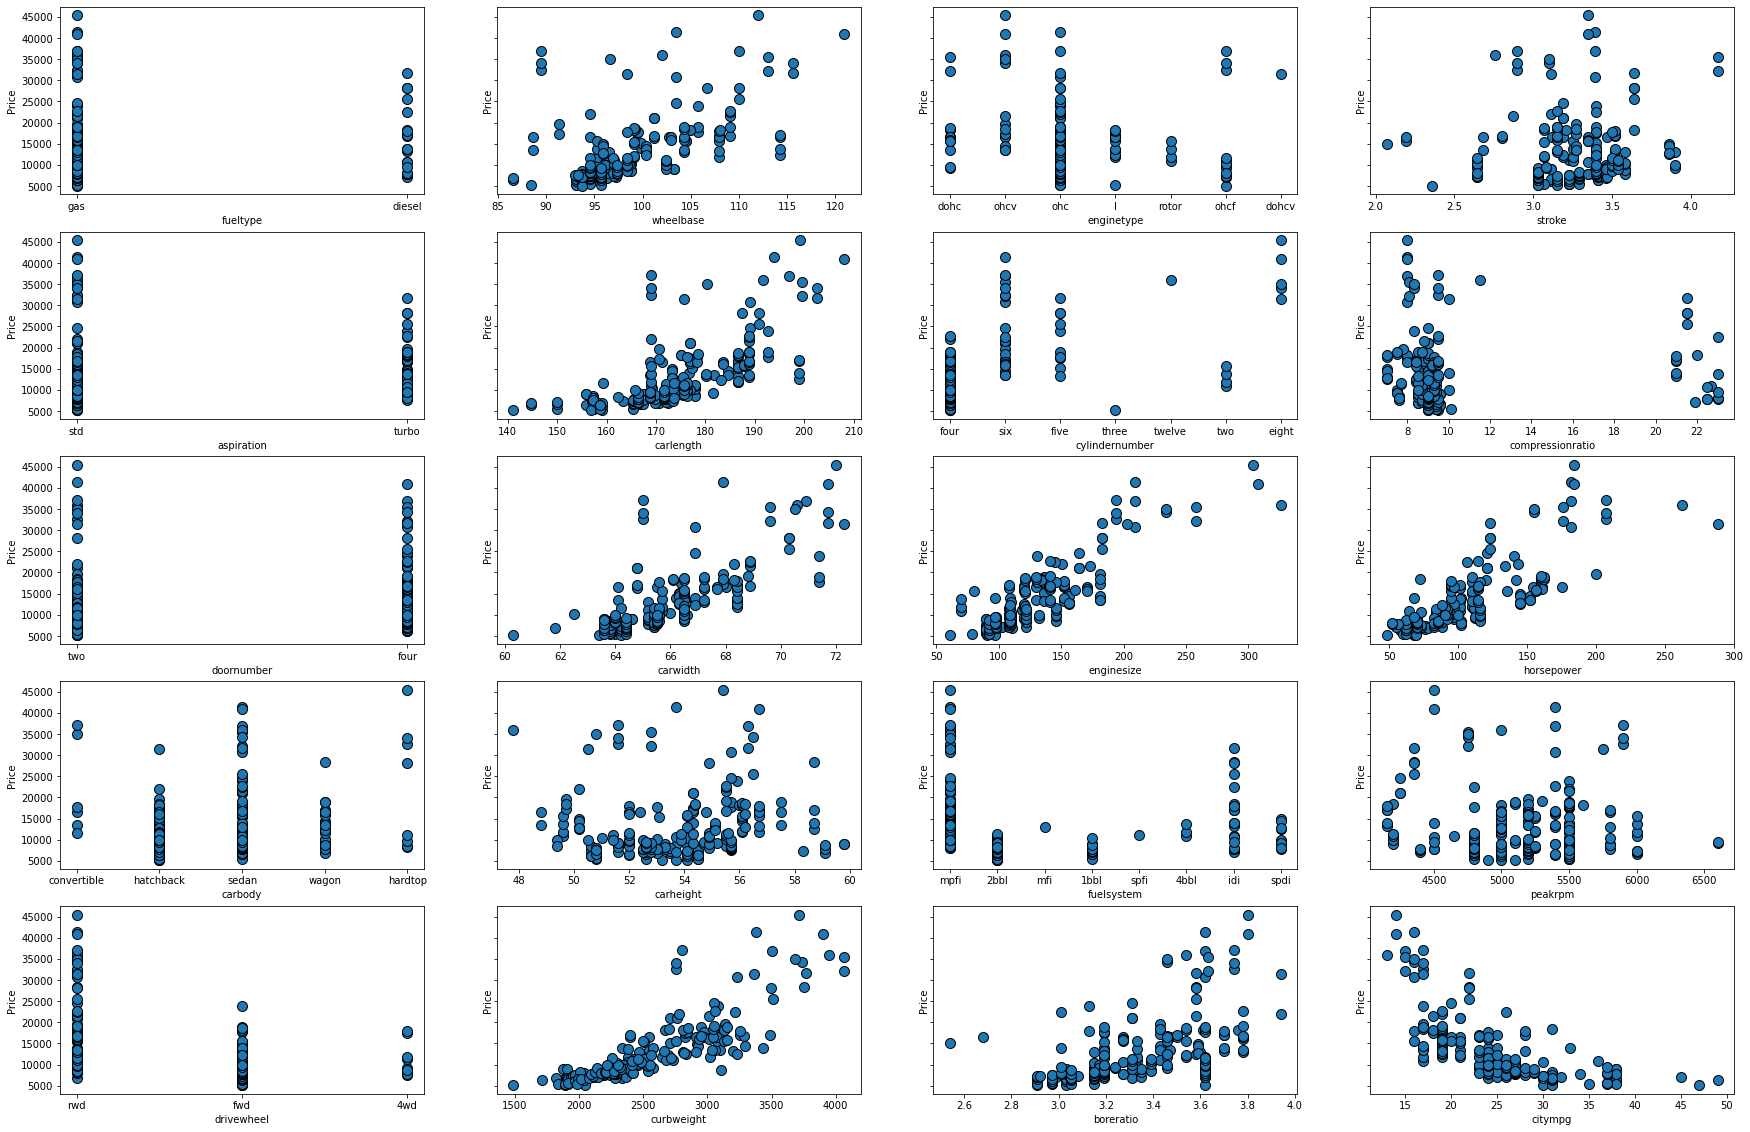

In [401]:
x = car_price_data.loc[:, ~car_price_data.columns.isin(["price", "car_ID", "symboling", "CarName", "enginelocation"])]
y = car_price_data[["price"]]
plt_dim = np.array([5,4])
fig, ax = plt.subplots(plt_dim[0], plt_dim[1], figsize = (30, 20), sharey = True)    
create_scatter_plot(ax, x, y, plt_dim[0], plt_dim[1])

The above plots show that most of the plots illustrate direct or inverse relationships with the price target variable. 

The features that appear to have a direct correlation with the target variable are

    - wheelbase, carlength, carwidth, enginesize, horsepower, curbweight, boreratio 
The features that appear to have an inverse correlation are 

    - drivewheel, citympg, highwaympg


## Feature Engineering
Features carlength and carwidth can be multiplied together to create a new feature, cararea 

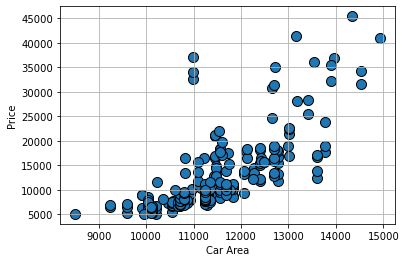

In [403]:
car_price_data["cararea"] = car_price_data["carlength"] * car_price_data["carwidth"]
car_price_data["carvolume"] = car_price_data["cararea"] * car_price_data["carheight"]
fig, ax = plt.subplots()    
ax.scatter(car_price_data[["cararea"]], car_price_data[["price"]], s = 100, edgecolor = "black")
ax.set_ylabel("Price"), ax.set_xlabel("Car Area")
plt.grid(True)
plt.show()

The area also seems to have a direct correlation with price. 

For our regression analysis, we select the following features that have a strong correlation with the target variable, price:
- cararea
- enginesize
- horsepower
- curbweight
- boreratio
- drivewheel
- citympg
- highwaympg

Before going into analysis, let's see the scales of the features
## Feature Scaling
We use histograms to show the range and distribution of the data for each feature. We then determine if any of the featuers need scaling.

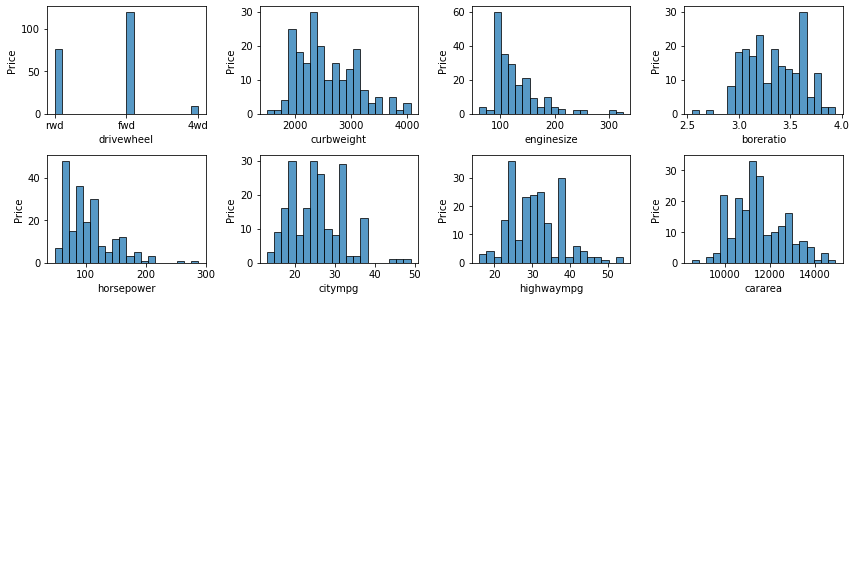

In [405]:
select_features = car_price_data.loc[:, car_price_data.columns.isin(["cararea", "enginesize", "horsepower", 
                                                                     "curbweight", "boreratio", "drivewheel",
                                                                    "citympg", "highwaympg"])]
target_var = car_price_data["price"]

fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (12, 8))
for j, ax in enumerate(axes.flatten()):
    if j < select_features.shape[1]:
        ax.hist(select_features.iloc[:,j], bins = 20, edgecolor = "black", alpha = 0.75)
        ax.set_xlabel(select_features.columns[j])
    else:
        ax.axis("off")
    ax.set_ylabel("Price")
plt.tight_layout()
plt.show()

The variables a wide range of scales, from tens (highwaympg) to tens of thousands (cararea). We will rescale all the selected features, except the drivewheel variable, which is categorical.

Variables could be normalized using z-score normalization as follows: $$ x_{in} = \frac{(x_i - \mu)}{\sigma} $$ where $\mu$ is the mean and $\sigma$ is the standard deviation. This ensures that the means are 0 and the standard deviations are 1.

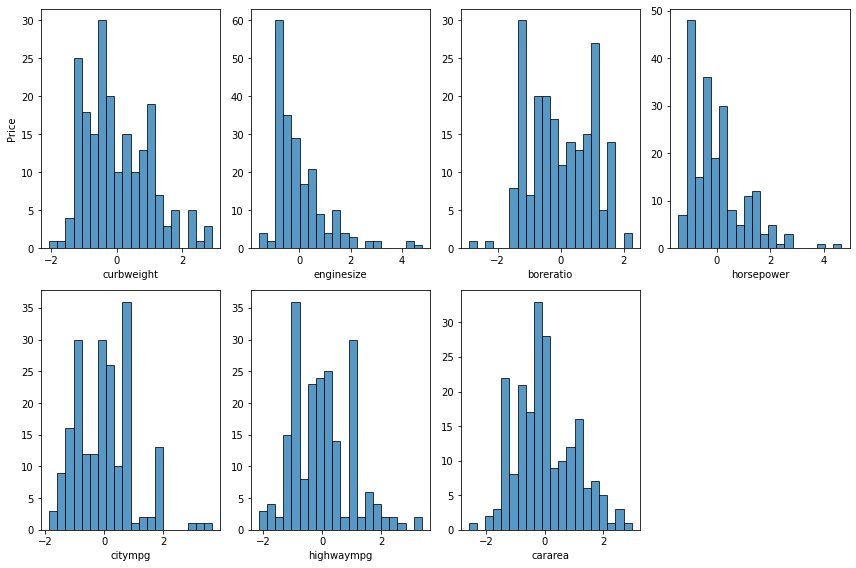

In [369]:
mu = np.mean(select_features, axis = 0)
sigma = np.std(select_features, axis = 0)
select_features_numeric = select_features.select_dtypes(include = [np.number])
select_features_norm = (select_features_numeric - mu)/sigma

#Alternatively, Scikit-learn can also be used to rescale
#scaler = StandardScaler()
#select_features_norm = scaler.fit_transform(select_features_numeric)

fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 8))
for k, ax in enumerate(axes.flatten()):
    if k < select_features_norm.shape[1]:
        ax.hist(select_features_norm.iloc[:,k], bins = 20, edgecolor = "black", alpha = 0.75)
        ax.set_xlabel(select_features_norm.columns[k])
        #ax.set_title("title")
    else:
        ax.axis("off")
axes[0,0].set_ylabel("Price")
plt.tight_layout()
plt.show()


## Predictions
Next, we prepare regression models to predict car prices. Let's classify our train and test sets. We then train our models with our training dataset and test them to make sure predictions work on dataset that is not used to train the models. 

Using, sklearn, we can split the dataset into train and test sets.

In [393]:
#rename variables ax x and y (x: features, y: target variable)
X = select_features_norm #selected and normalized features
y = target_var #price
#split 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

Fit a regression model 

In [407]:
sgdr = SGDRegressor(max_iter = 1000)
sgdr.fit(X_train, y_train)
print(f"The number of iterations is {sgdr.n_iter_}.")
y_pred = sgdr.predict(X_test)

The number of iterations is 34.


Plot actual and predicted values of the target variable

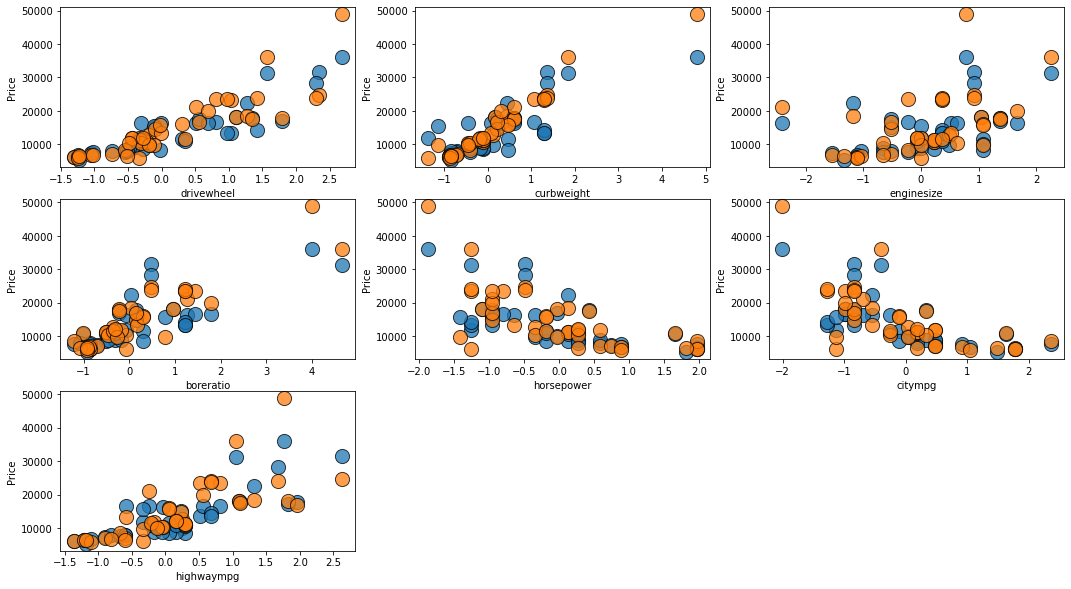

In [395]:
#Plot predictions and actual values of "price"
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (18, 10))
k = 0
for j, ax in enumerate(axes.flatten()):
    if j < X_test.shape[1]:
        ax.scatter(X_test.iloc[:,j], y_test, edgecolor = "black", alpha = 0.75, label = "actual", s = 200)
        ax.scatter(X_test.iloc[:,j], y_pred, edgecolor = "black", alpha = 0.75, label = "predicted", s = 200)
        ax.set_xlabel(select_features.columns[j])
    else:
        ax.axis("off")
    ax.set_ylabel("Price")
plt.show()

## Model Evaluation
Root mean squared errors (RMSE) and accuracy score are used to evaluate the model. 

In [409]:
#Calculate RMSE

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred) 
print(f"Model evaluation: \n\t\t RMSE = {round(rmse)} \n\t\t R^2 = {round(r2,2)}")

Model evaluation: 
		 RMSE = 4579 
		 R^2 = 0.59


The model evaluation reveals that the regression model needs to be improved or other methods should be tested for a better fit. 